# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools

In [3]:
MEASURE_X = True
DELTA = 0.3

# Helpers

In [4]:
def run_circuit(params, N, measure_x=MEASURE_X):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]

    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    if measure_x:
        cirq.append(jqtc.Ry(-jnp.pi/2), 0)
        cirq.append(jqtc.MZ_plus(), 0, default_simulate_mode="kraus")

    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()

def fid_metric(params, target_state):
    N = target_state.dims[0][1]
    prepared_state = run_circuit(params, N)
    return jnp.real(jqt.overlap(target_state, prepared_state))

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0, None))

def metric(params, target_state):
    fids = fid_metric_vmap(params, target_state)
    losses = jnp.log(1 - fids)
    avg_loss = jnp.average(losses)
    return avg_loss

def cf_tomography_circuit(state, beta):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi/2), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    cirq.append(jqtc.Ry(-jnp.pi/2), 0)
    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

def sim_cf(osc_state):
    if osc_state.is_dm():
        state = jqt.ket2dm(jqt.basis(2,0)) ^ osc_state
    else:
        state = jqt.basis(2,0) ^ osc_state

    # Plot CF
    betas_re = jnp.linspace(-4,4, 101)
    betas_im = jnp.linspace(-4,4, 101)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    betas_flat = betas.flatten()

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta)))
    tomo_res = cf_tomography_circuit_vmap(betas_flat)
    tomo_res = tomo_res.reshape(*betas.shape)

    return tomo_res, betas_re, betas_im


def calculate_cf(osc_state, betas_re=None, betas_im=None):
    # Plot CF
    N = osc_state.dims[0][0]

    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 41)
    betas_im = betas_im if betas_im is not None else jnp.linspace(-4,4, 41)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    
    cf_vals = np.zeros((len(betas_re), len(betas_im)), dtype=jnp.complex64)
    for j in tqdm(range(len(betas_re))):
        for k in range(len(betas_im)):
            cf_vals[j,k] = jqt.overlap(jqt.displace(N, betas[j,k]), osc_state)
    return cf_vals, betas_re, betas_im


# Tests

Text(0.5, 1.0, 'Fidelity: 1.0000+0.0000j')

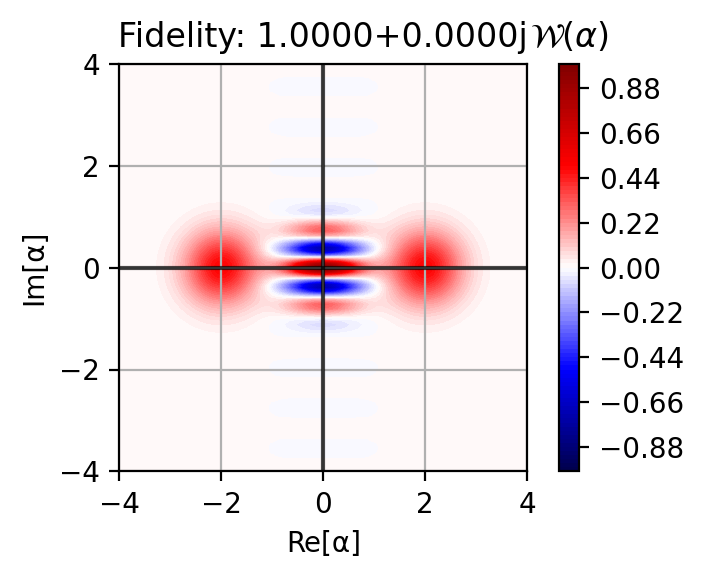

In [5]:
params = jnp.array([[0.0,0.0], [0.25,0.0], [4,0.0], [0.0,0.0]])

N = 50
final_state = run_circuit(
    params, N
)

state = final_state

cat_state = (jqt.coherent(N, 2) + jqt.coherent(N, -2)).unit()
cat_state = jqt.basis(2,0) ^ cat_state
fid = jqt.overlap(state, cat_state)
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title(f"Fidelity: {fid:.4f}")

# Target (set this)

Text(0.5, 1.0, 'GKP Squeezing level: 10.46 dB')

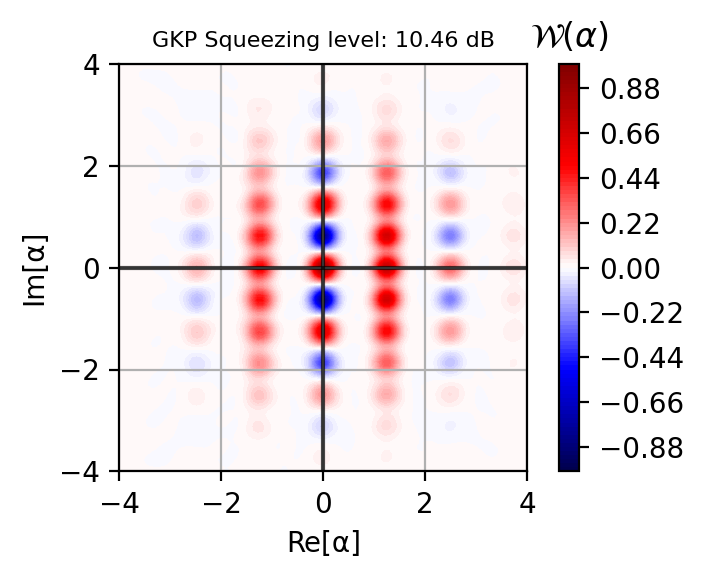

In [6]:
mode = "gkp"

if mode == "gkp":
    delta = DELTA
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": 50})
    squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))

    target_state_cavity = gkp_qubit.basis["-z"]
    title = f"GKP Squeezing level: {squeezing_level:.2f} dB"

elif mode == "fock_1":
    N = 20
    target_state_cavity = jqt.basis(N, 1)
    title = f"Fock state |1> (N={N})"

target_state = jqt.basis(2,0) ^ target_state_cavity

pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_cavity, pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title(title, fontsize=8)

In [7]:
metric(jnp.array([params,2*params]), target_state)

Array(-0.11726111, dtype=float64)

# Batch Gradient Descent

In [8]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Parameters
key = jax.random.PRNGKey(0)  # Initialize a random key
B = 100 # Batch size
num_blocks = 6
lower_bounds = jnp.array([-1, -1, -4, -4])  # Define the lower bounds for each axis
upper_bounds = jnp.array([1, 1, 4, 4])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, target_state)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, target_state).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, target_state)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, target_state).block_until_ready()

9.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []

epochs = 500
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params, target_state))
  metric, grads = metric_val_and_grad(params, target_state)
  metric_history.append(metric)

  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metric:.4f}, best fid = {jnp.max(fids_history[-1])}")

  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

params_history = jnp.array(params_history)
fids_history = jnp.array(fids_history)
metric_history = jnp.array(metric_history)

  0%|          | 1/500 [00:04<39:16,  4.72s/it]

Epoch 0: metric = -0.0370, best fid = 0.2497659336977312


  2%|▏         | 11/500 [00:45<42:42,  5.24s/it]

Epoch 10: metric = 0.0000, best fid = 0.0


  3%|▎         | 17/500 [01:05<32:04,  3.98s/it]

: 

In [9]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\EQuS\AppData\Local\Temp\ipykernel_28500\790125059.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
C:\Users\EQuS\AppData\Local\Temp\ipykernel_28500\790125059.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")


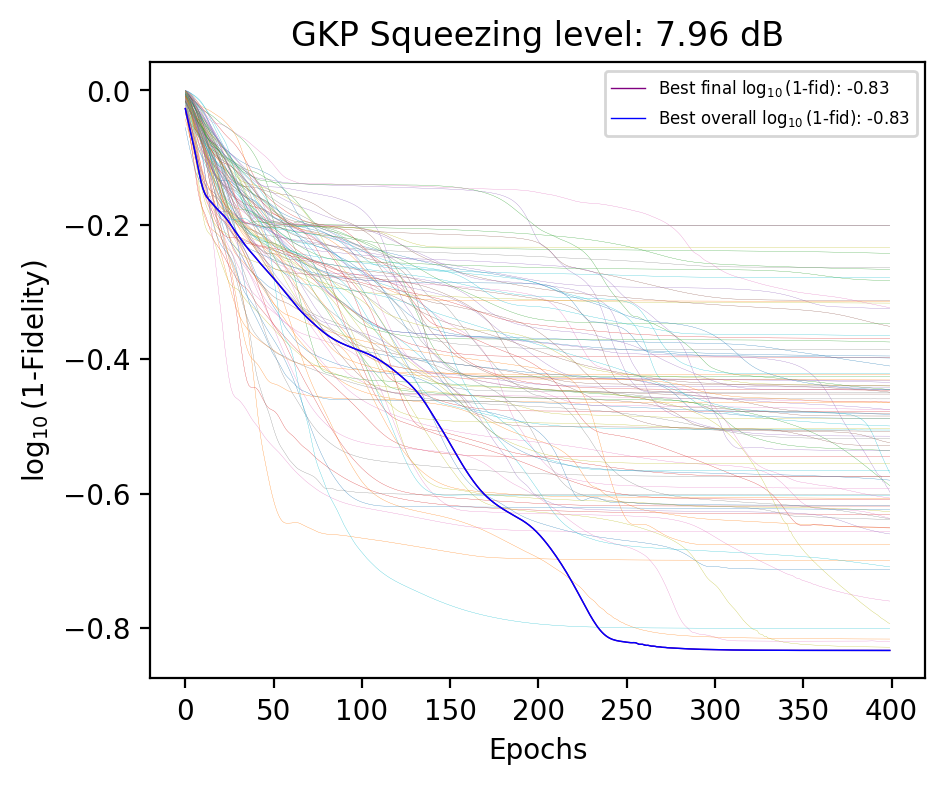

In [10]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(title)
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

# Plotting Optimal

In [11]:
best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]

In [12]:
params_input = {
    "gammas_x": best_params[0].tolist(),
    "gammas_y": best_params[1].tolist(),
    "betas_re": best_params[2].tolist(),
    "betas_im": best_params[3].tolist(),
    "final_x_basis_measurement": False,
}

for key, value in params_input.items():
    if isinstance(value, bool):
        continue
    params_input[key] = [np.round(v,6) for v in value]



In [7]:
params_input = np.load("data/gkp_delta_0p4_20250522.npz", allow_pickle=True)["best_params"][()]
best_params = jnp.array([params_input["gammas_x"], params_input["gammas_y"], params_input["betas_re"], params_input["betas_im"]])

In [ ]:
# np.savez("data/gkp_delta_0p4_20250522.npz", best_params=params_input)

In [62]:
# best_params = jnp.array([
#     [0.0,0.0,0.5],
#     [0.0,0.0,0.0],
#     [3.0,0.0,3.0],
#     [0.0,3.0,3.0]
# ]
# )

Best parameters: 
 [[ 0.188791  0.453101  0.537309  0.916509  0.245767  0.070099]
 [ 0.970305  0.655541  0.343788  0.41966   0.221418  0.755799]
 [-0.126968  0.465182 -1.132842 -2.783795  0.005875 -0.044698]
 [-2.217091  1.12213   1.135798  1.046693  0.599786  0.846184]]


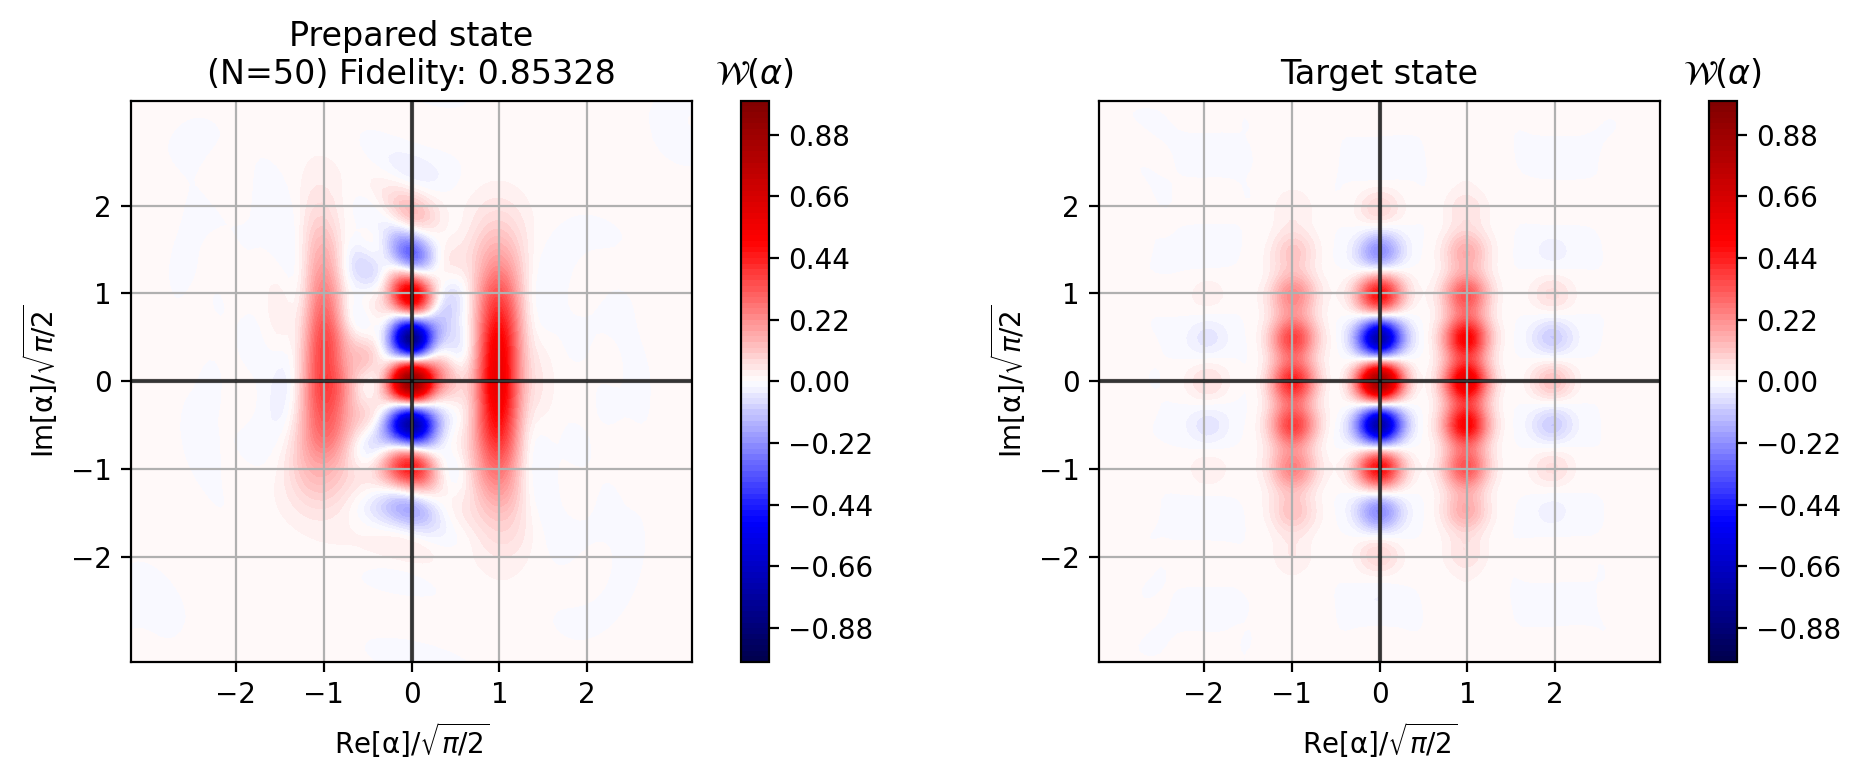

In [8]:
print("Best parameters: \n", best_params)

if mode == "gkp":
    N = 50
    gkp_qubit_larger = jqtb.GKPQubit({"delta": delta, "N": N})
    target_state_larger = jqt.basis(2,0) ^ gkp_qubit_larger.basis["-z"]
elif mode == "fock_1":
    N = 50
    target_state_larger = jqt.basis(2,0) ^ jqt.basis(N, 1) 

fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

prepared_state = run_circuit(best_params, N)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(prepared_state,1), pts, ax=axs[0], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
# ax.set_title("Prepared state\n" + f"(N=50) Fidelity: {best_fid:.5f}\n" + f"(N={N}) Fidelity: {fid:.5f}")
ax.set_title("Prepared state\n" + f"(N={N}) Fidelity: {fid:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger.ptrace(1), pts, ax=axs[1], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
ax.set_title("Target state")

fig.tight_layout()

In [49]:
betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = calculate_cf(prepared_state.ptrace(1), betas_re, betas_im)

100%|██████████| 101/101 [00:14<00:00,  6.86it/s]


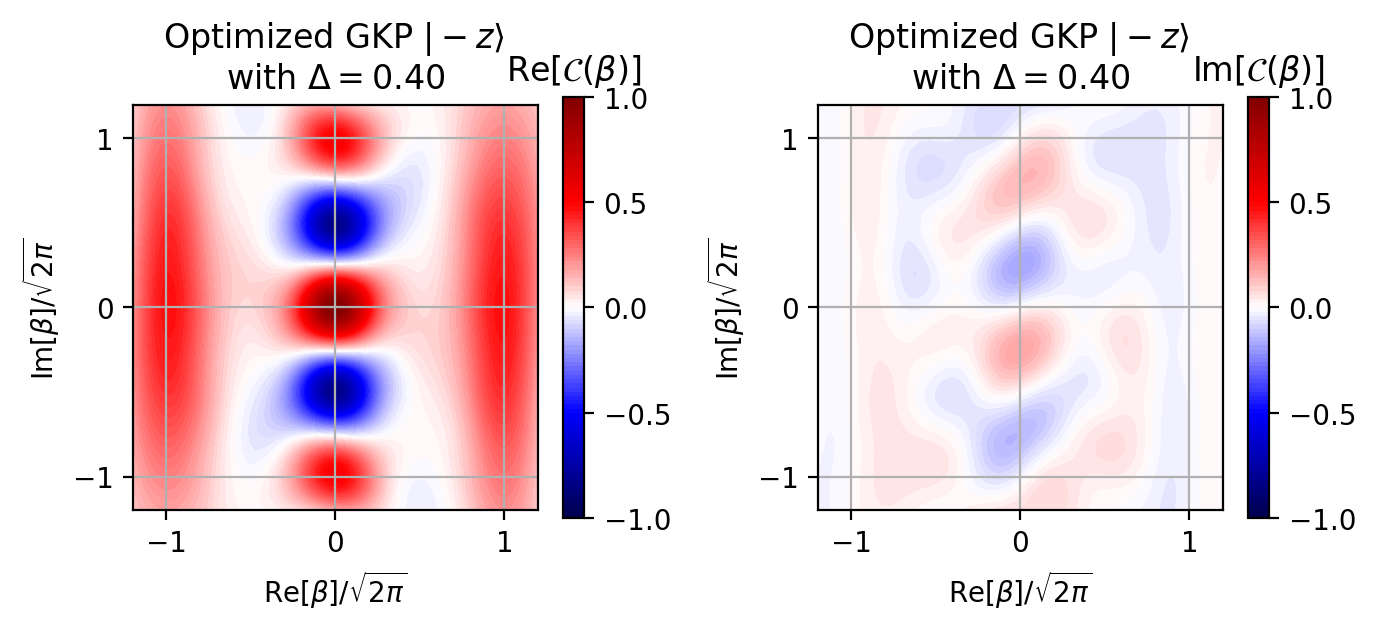

In [52]:
fig, axs = plt.subplots(1,2, figsize=(7, 3), dpi=200)


for j, ax in enumerate(axs):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    ax.set_title(r"Optimized GKP $|-z\rangle$ " + "\n" + r"with $\Delta = $" + f"{delta:.2f}")
fig.tight_layout()

# Debugging

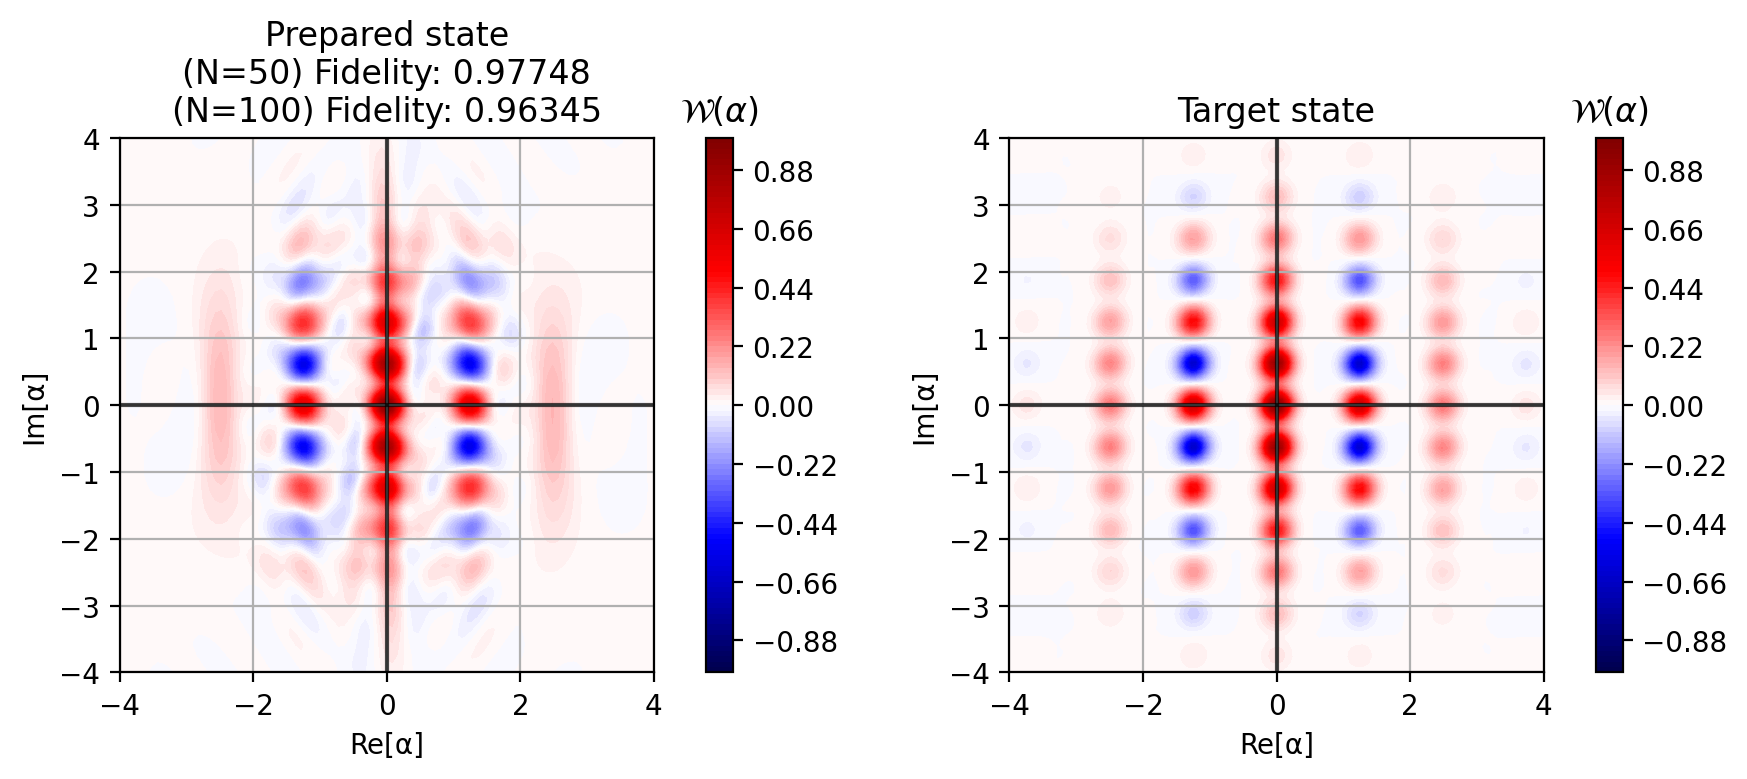

In [127]:
best_params = jnp.array([[ 0.50012385,  0.39523304, -0.3275471 , -0.09874416],
[ 0.2490166 ,  0.50010219,  0.50048423, -0.49811903],
[-2.27944313,  0.12582531, -0.34547531, -2.11939675],
[ 3.28548294, -1.94665808, -1.94882969, -2.94004652]])


fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

fids = []
N_list = [50, 100]
for N in N_list:
    delta = 0.3
    gkp_qubit_larger = jqtb.GKPQubit({"delta": delta, "N": N})
    target_state_larger = gkp_qubit_larger.basis["+z"]
    state = run_circuit (best_params[:,:4], N)
    prepared_state = jqt.ptrace(state,1)
    fids.append(jnp.real(jqt.overlap(target_state_larger, prepared_state)))

pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"(N={N_list[0]}) Fidelity: {fids[0]:.5f}\n" + f"(N={N_list[1]}) Fidelity: {fids[1]:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()
fig.tight_layout()

In [128]:
tomo_res, betas_re, betas_im = calculate_cf(prepared_state)
tomo_res_plot = jnp.real(tomo_res)

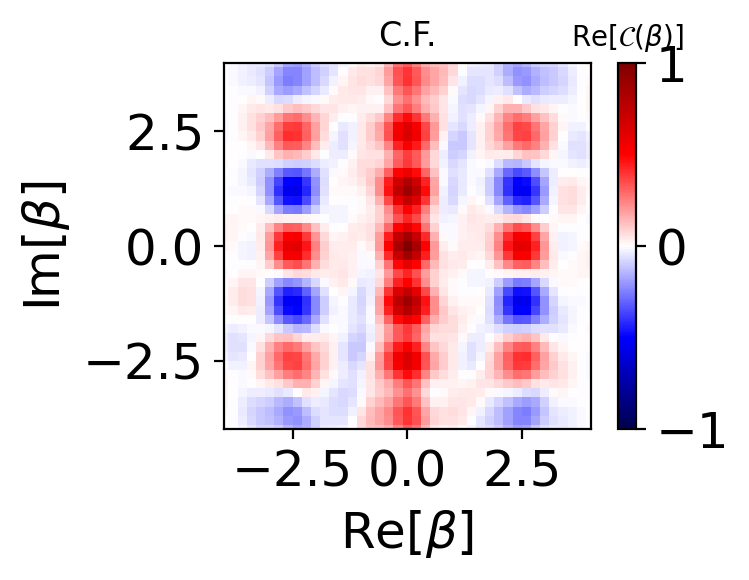

In [129]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.pcolormesh(betas_re, betas_im, tomo_res_plot.T, cmap='seismic', vmax=1, vmin=-1)

ax.set_xlabel(r'Re[$\beta$]', fontsize=18)
ax.set_ylabel(r'Im[$\beta$]', fontsize=18)
# ax.set_xticks([-2,0,2])
# ax.set_yticks([-2,0,2])
lims = [-4,4]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.tick_params(labelsize=18)

ax.set
ax.grid(False)
ax.set_title('C.F.')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_title(r"Re[$\mathcal{C}(\beta)$]", fontsize=10)
# cbar.ax.set_title(r'$\langle \hat{\sigma}_x \rangle$', fontsize=18)
# cbar.ax.set_yticks([-0.5, 0, 0.5, 1])
cbar.ax.tick_params(labelsize=18)

ax.set_aspect('equal')
fig.tight_layout()
